# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio

# Fourier Transform

In [2]:
near = iio.imread('near_original.jpg')
near = 0.299*near[:,:,0] + 0.587*near[:,:,1] + 0.114*near[:,:,2]
iio.imwrite('near_image.jpg', np.uint8(near))

far = iio.imread('far_original.jpg')
far = 0.299*far[:,:,0] + 0.587*far[:,:,1] + 0.114*far[:,:,2]
iio.imwrite('far_image.jpg', np.uint8(far))

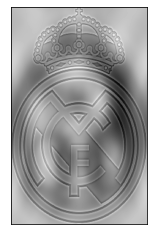

In [11]:
def gaussian_filter(img, sigma):
    x, y = img.shape
    i = np.linspace(0,x,x)
    j = np.linspace(0,y,y)
    filt1 = np.exp(-(i-x//2)**2/(2*sigma**2))
    filt2 = np.exp(-(j-y//2)**2/(2*sigma**2))
    filt = np.outer(filt1, filt2)
    return filt/np.max(filt)

def cutoff(img, freq, lp=True):
    x, y = img.shape
    for i in range(x):
        for j in range(y):
            if (i-x//2)**2+(j-y//2)**2 >= freq**2 and lp:
                img[i,j] = 0
            elif (i-x//2)**2+(j-y//2)**2 <= freq**2 and not lp:
                img[i,j] = 0
    return img
                
                
def hybrid(near, far, sigma_near, sigma_far, cutoff_near, cutoff_far, alpha, beta):
    
    # fourier transform
    f_near = np.fft.fftshift(np.fft.fft2(near))
    iio.imwrite('near_before_filter.jpg', np.uint8(np.abs(20*np.log10(f_near+1e-3))))
    f_far = np.fft.fftshift(np.fft.fft2(far))
    iio.imwrite('far_before_filter.jpg', np.uint8(np.abs(20*np.log10(f_far+1e-3))))
    
    # create filters
    filt_near = 1 - gaussian_filter(f_near, sigma_near)
    filt_far = gaussian_filter(f_far, sigma_far)
    
    # filtering
    f_near = f_near * filt_near
    f_far = f_far * filt_far
    
    
    # cutoff
    f_near = cutoff(f_near, cutoff_near, lp=False)
    iio.imwrite('near_after_filter.jpg', np.uint8(np.abs(20*np.log10(f_near+1e-3))))
    f_far = cutoff(f_far, cutoff_far)
    iio.imwrite('far_after_filter.jpg', np.uint8(np.abs(20*np.log10(f_far+1e-3))))
    
    # create new image
    f = np.zeros(f_near.shape, dtype='complex')
    
    x, y = f.shape
    for i in range(x):
        for j in range(y):
            if (i-x//2)**2+(j-y//2)**2 <= cutoff_near**2:
                f[i,j] = f_far[i,j]
            elif (i-x//2)**2+(j-y//2)**2 >= cutoff_far**2:
                f[i,j] = f_near[i,j]
            else:
                f[i,j] = (alpha*f_near[i,j]+beta*f_far[i,j])/(alpha+beta)
    
    out = np.abs(np.fft.ifft2(np.fft.ifftshift(f)))
    out = out/np.max(out)*255
    return np.uint8(out)

img = hybrid(near, far, 30, 30, 4.5, 15, 10, 1)
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
iio.imwrite('hybrid_image.jpg', img)